## Predicting antigen specificity 

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv('vdjdb.csv')

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92771 entries, 0 to 92770
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   complex.id        92771 non-null  int64 
 1   gene              92771 non-null  object
 2   cdr3              92771 non-null  object
 3   v.segm            92670 non-null  object
 4   j.segm            91626 non-null  object
 5   species           92771 non-null  object
 6   mhc.a             92771 non-null  object
 7   mhc.b             92771 non-null  object
 8   mhc.class         92771 non-null  object
 9   antigen.epitope   92771 non-null  object
 10  antigen.gene      92709 non-null  object
 11  antigen.species   92771 non-null  object
 12  reference.id      91260 non-null  object
 13  method            92771 non-null  object
 14  meta              92771 non-null  object
 15  cdr3fix           92771 non-null  object
 16  vdjdb.score       92771 non-null  int64 
 17  web.method  

In [3]:
dataset.isnull().sum()

complex.id             0
gene                   0
cdr3                   0
v.segm               101
j.segm              1145
species                0
mhc.a                  0
mhc.b                  0
mhc.class              0
antigen.epitope        0
antigen.gene          62
antigen.species        0
reference.id        1511
method                 0
meta                   0
cdr3fix                0
vdjdb.score            0
web.method             0
web.method.seq         0
web.cdr3fix.nc         0
web.cdr3fix.unmp       0
dtype: int64

# Data Transformation

## Removing Unwanted Columns

Some of the columns contain specific information about the literature sources (reference.id), sequencing methods (method, web.method.seq), collection method (web.method) etc., some of which are related to how **vdjdb.score** is calculated.

Therefore we first remove these columns. Deleted columns are as follows: 
-  reference.id
-  method
-  meta
-  cdr3fix
-  web.method  
-  web.method.seq
-  web.cdr3fix.nc
-  web.cdr3fix.unmp

(Work by Yutong)

In [4]:
dataset = dataset.iloc[:, list(range(0, 12)) + [16]]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92771 entries, 0 to 92770
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   complex.id       92771 non-null  int64 
 1   gene             92771 non-null  object
 2   cdr3             92771 non-null  object
 3   v.segm           92670 non-null  object
 4   j.segm           91626 non-null  object
 5   species          92771 non-null  object
 6   mhc.a            92771 non-null  object
 7   mhc.b            92771 non-null  object
 8   mhc.class        92771 non-null  object
 9   antigen.epitope  92771 non-null  object
 10  antigen.gene     92709 non-null  object
 11  antigen.species  92771 non-null  object
 12  vdjdb.score      92771 non-null  int64 
dtypes: int64(2), object(11)
memory usage: 9.2+ MB


In [5]:
dataset.head(5)

,complex.id,gene,cdr3,v.segm,j.segm,species,mhc.a,mhc.b,mhc.class,antigen.epitope,antigen.gene,antigen.species,vdjdb.score
0,1,TRA,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,2
1,1,TRB,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,2
2,0,TRB,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,2
3,2,TRA,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,2
4,2,TRB,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,2


---

## How to filter the dataset

1. Using only beta chains  -- The CDR3 regions of TCRβ chains are located in the center of the paratope and are considered as the key determinant of specificity in antigen recognition (Jiang, Huo and Cheng Li, 2023). Moreover, the database contain mostly beta chained samples. -- <b>Done</b>
2. Only taking human species (Why?)  -- <b>Done</b>
    1. Most samples
3. Removed duplicates -- <b>Done</b>
3. Restricted to MHC Class 1 (Why?)  - <b>Not Sure?</b>
    1. There are around 80K records of MHC class 1
    2. The TIENET paper maybe focused mainly on MHC1 only

---
4. <b> only kept the CDR3β and epitope sequences whose lengths lie between 5–30 and 7–15 amino acids, respectively (Why?) </b>
    1. This was likely done to focus the model on reasonable sequence lengths and remove potentially noisy or erroneous data. (Explore more)
    2. CDR3s with lengths between 10-20  -- <b> Done </b>


#### Explanation for CDR3 Lengths
The optimal length for the CDR3 region in predicting TCR-peptide interactions can vary depending on the specific dataset and model used. However, most studies suggest that the CDR3 loop sequence's mid-region creates most of the contacts with the peptide due to its length and flexibility[3]. The CDR3 region is typically 10-20 amino acids long, and its length can impact antigen specificity[3].

In the case of the VDJ.db dataset, the authors report that the CDR3 loop sequence's mid-region creates most of the contacts with the peptide due to the loop and peptide's flexibility[3]. They also demonstrate that the modeling pipeline can be used to study features of residue interactions in TCR:pMHC complexes, providing access to structural data for immunologists and in silico structural modeling[3].

When dealing with the VDJ.db dataset, it is essential to consider the specific length of the CDR3 region for predicting TCR-peptide interactions. The optimal length may depend on the specific dataset and model used, but generally, a CDR3 region of 10-20 amino acids is considered suitable for predicting TCR-peptide interactions.
    
Citations:
[3] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10464843/

#### Explanation for epitope lengths

In the context of immunology and T-cell receptor (TCR) research, the length of 7–15 amino acids for epitopes is commonly used because this range represents the typical length of peptides that can be presented by Major Histocompatibility Complex (MHC) molecules to TCRs. MHC molecules play a crucial role in the immune response by presenting peptide fragments derived from pathogens to TCRs on T cells, which are then able to recognize and respond to these peptides. The peptides that bind to Class I MHC molecules are generally 8-10 amino acids in length, while those that bind to Class II MHC molecules are often longer, ranging from 13 to 25 amino acids, with a core region of about 9 amino acids that interacts most directly with the TCR


---
5. Removing epitopes with less than 10 associated TCR sequences: (Why?) <b> Done </b>
    1. The merged dataset was highly imbalanced, with some epitopes having many associated TCRs and others having very few.
    2. To address this imbalance, the authors removed epitopes that had less than 10 associated TCR sequences.
    3. This ensured a minimum number of examples for each epitope, which can help the model learn more robust patterns.
6. Removing TCR sequences with ambiguous amino acids (Why?) -- <b> Done </b>
    1. Some TCR sequences contained ambiguous amino acid characters (B, J, O, U, X), which the authors removed.
6. I should keep both positive and negative dataset. (Why?)
    1. All the records in the VDJ db are positive dataset with varying confidence scores, since there are only 1400 records with high confidence score. I will make use of only the high confidence scores and it will be biased towards high confidence records

## How to prepare the data for ML model?

1. Encoding the input sequences: (Is this process too complex?)
    1. The authors used two separate pre-trained TCRpeg models to encode the TCR (CDR3β) and epitope sequences into numerical vector representations.
        2. This transfer learning approach was used to leverage the knowledge learned from the pre-training tasks.
        3. 
    2. catElmo technique -
        1. https://elifesciences.org/reviewed-preprints/88837v1
        2. https://github.com/Lee-CBG/catELMo
    3. Blossom
   
   
<spam color='red'>?? Why do we combine peptide and TCRs before putting them into a model?</spam>

## Which ML algo to use?

1. The encoded TCR and epitope vectors were concatenated and fed into the final fully connected neural network (FCN) of the TEINet model (Is this too complex?)

## Using hyper-parameters

---

# TASK 6

## How valueable is the different lengths of the CDR

In [6]:
sample_dataset = dataset[['cdr3','antigen.epitope','vdjdb.score','species','antigen.species','gene','mhc.class']]

#### Taking only beta chains of humans

In [7]:
sample_dataset = sample_dataset[(sample_dataset['gene'] == 'TRB') & (sample_dataset['species'] == 'HomoSapiens')]

In [8]:
sample_dataset.head(5)

,cdr3,antigen.epitope,vdjdb.score,species,antigen.species,gene,mhc.class
1,CASSYLPGQGDHYSNQPQHF,FLKEKGGL,2,HomoSapiens,HIV-1,TRB,MHCI
2,CASSFEAGQGFFSNQPQHF,FLKEKGGL,2,HomoSapiens,HIV-1,TRB,MHCI
4,CASSFEPGQGFYSNQPQHF,FLKEKGGL,2,HomoSapiens,HIV-1,TRB,MHCI
6,CASSYEPGQVSHYSNQPQHF,FLKEKGGL,2,HomoSapiens,HIV-1,TRB,MHCI
8,CASSALASLNEQFF,FLKEKGGL,2,HomoSapiens,HIV-1,TRB,MHCI


### Creating subset for positive and negative sampling

In [9]:
# positive = sample_dataset[sample_dataset['vdjdb.score'] > 1]
# negative = sample_dataset[sample_dataset['vdjdb.score'] < 2]

### Removing Duplicates

In [10]:
sample_dataset.columns

Index(['cdr3', 'antigen.epitope', 'vdjdb.score', 'species', 'antigen.species',
       'gene', 'mhc.class'],
      dtype='object')

In [11]:
duplicate_indexes = sample_dataset[sample_dataset.duplicated(keep='last')].index
duplicate_indexes

Int64Index([   30,    31,    33,    37,   104,   154,   171,   221,   233,
              398,
            ...
            92726, 92728, 92732, 92734, 92738, 92746, 92750, 92752, 92754,
            92756],
           dtype='int64', length=7824)

In [12]:
sample_dataset.drop(index=duplicate_indexes,inplace=True)

In [13]:
sample_dataset.head(10)

,cdr3,antigen.epitope,vdjdb.score,species,antigen.species,gene,mhc.class
1,CASSYLPGQGDHYSNQPQHF,FLKEKGGL,2,HomoSapiens,HIV-1,TRB,MHCI
2,CASSFEAGQGFFSNQPQHF,FLKEKGGL,2,HomoSapiens,HIV-1,TRB,MHCI
4,CASSFEPGQGFYSNQPQHF,FLKEKGGL,2,HomoSapiens,HIV-1,TRB,MHCI
6,CASSYEPGQVSHYSNQPQHF,FLKEKGGL,2,HomoSapiens,HIV-1,TRB,MHCI
8,CASSALASLNEQFF,FLKEKGGL,2,HomoSapiens,HIV-1,TRB,MHCI
10,CASSYLPGQGDHYSNQPQHF,FLKEQGGL,2,HomoSapiens,HIV-1,TRB,MHCI
11,CASSFEAGQGFFSNQPQHF,FLKEQGGL,2,HomoSapiens,HIV-1,TRB,MHCI
13,CASSFEPGQGFYSNQPQHF,FLKEQGGL,2,HomoSapiens,HIV-1,TRB,MHCI
15,CASSYEPGQVSHYSNQPQHF,FLKEQGGL,2,HomoSapiens,HIV-1,TRB,MHCI
17,CASSYLPGQGDHYSNQPQHF,FLKETGGL,2,HomoSapiens,HIV-1,TRB,MHCI


# CDR3 Lengths

## Adding column of length of CDR3 chain

In [14]:
sample_dataset['CDR3_Length'] = sample_dataset.apply(lambda row: len(row['cdr3']),axis=1)

In [15]:
cdr3_length_count = sample_dataset.groupby(by=['CDR3_Length']).size().to_frame('count_of_records').reset_index()

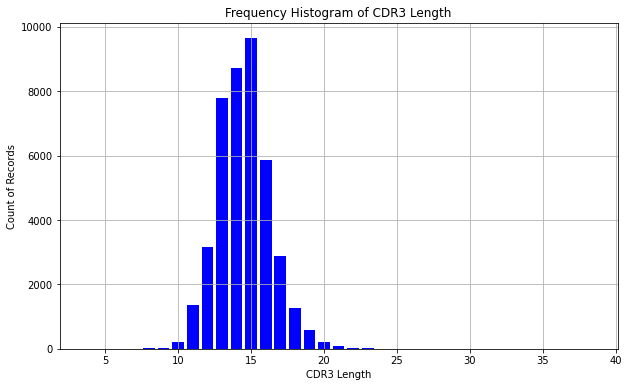

In [16]:
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(cdr3_length_count['CDR3_Length'], cdr3_length_count['count_of_records'], width=0.8, color='b')
plt.xlabel('CDR3 Length')
plt.ylabel('Count of Records')
plt.title('Frequency Histogram of CDR3 Length')
plt.grid(True)
plt.show()

In [17]:
sample_dataset.head(10)

,cdr3,antigen.epitope,vdjdb.score,species,antigen.species,gene,mhc.class,CDR3_Length
1,CASSYLPGQGDHYSNQPQHF,FLKEKGGL,2,HomoSapiens,HIV-1,TRB,MHCI,20
2,CASSFEAGQGFFSNQPQHF,FLKEKGGL,2,HomoSapiens,HIV-1,TRB,MHCI,19
4,CASSFEPGQGFYSNQPQHF,FLKEKGGL,2,HomoSapiens,HIV-1,TRB,MHCI,19
6,CASSYEPGQVSHYSNQPQHF,FLKEKGGL,2,HomoSapiens,HIV-1,TRB,MHCI,20
8,CASSALASLNEQFF,FLKEKGGL,2,HomoSapiens,HIV-1,TRB,MHCI,14
10,CASSYLPGQGDHYSNQPQHF,FLKEQGGL,2,HomoSapiens,HIV-1,TRB,MHCI,20
11,CASSFEAGQGFFSNQPQHF,FLKEQGGL,2,HomoSapiens,HIV-1,TRB,MHCI,19
13,CASSFEPGQGFYSNQPQHF,FLKEQGGL,2,HomoSapiens,HIV-1,TRB,MHCI,19
15,CASSYEPGQVSHYSNQPQHF,FLKEQGGL,2,HomoSapiens,HIV-1,TRB,MHCI,20
17,CASSYLPGQGDHYSNQPQHF,FLKETGGL,2,HomoSapiens,HIV-1,TRB,MHCI,20


In [18]:
## Remove rows which have CDR3 lengths < 10 or > 20
sample_dataset = sample_dataset[(sample_dataset['CDR3_Length'] >= 10) & (sample_dataset['CDR3_Length'] <= 20)]

## Finding Epitope Lengths

In [19]:
sample_dataset['Epitope_Length'] = sample_dataset.apply(lambda row: len(row['antigen.epitope']),axis=1)

In [20]:
epitope_length_count = sample_dataset.groupby(by=['Epitope_Length']).size().to_frame('count_of_records').reset_index()

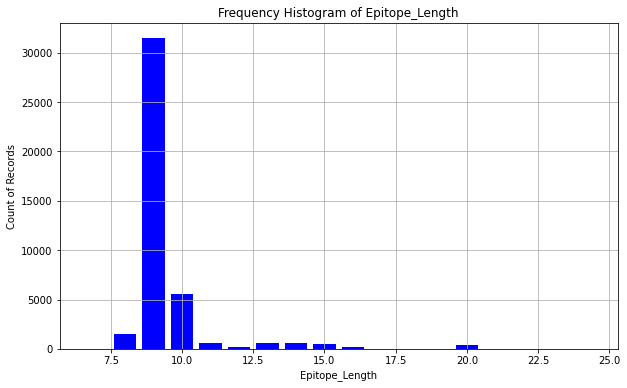

In [21]:
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(epitope_length_count['Epitope_Length'], epitope_length_count['count_of_records'], width=0.8, color='b')
plt.xlabel('Epitope_Length')
plt.ylabel('Count of Records')
plt.title('Frequency Histogram of Epitope_Length')
plt.grid(True)
plt.show()

## Taking only those epitopes which have 10 or more associated TCR sequences

In [22]:
group_antigen_cdr3 = sample_dataset.groupby(['antigen.epitope'])['cdr3'].unique().to_frame('cdr3_found').reset_index()

In [23]:
group_antigen_cdr3['cdr3_found_count'] = group_antigen_cdr3['cdr3_found'].apply(lambda x:len(x))

In [24]:
group_antigen_cdr3_count = group_antigen_cdr3.groupby(by=['cdr3_found_count']).size().to_frame('count').reset_index()

In [25]:
group_antigen_cdr3_count.sort_values('count',ascending=False).to_csv('group_antigen_cdr3_count.csv',index=False)

In [26]:
antigen_needed_list = group_antigen_cdr3[group_antigen_cdr3['cdr3_found_count'] >= 10]['antigen.epitope']

In [27]:
antigen_needed_list[:10]

8      AIFYLITPV
29     ALSKGVHFV
33     ALWEIQQVV
41     AMFWSVPTV
62     ARMILMTHF
64     ATDALMTGF
65     ATDALMTGY
71    AVFDRKSDAK
77     AYAQKIFKI
79     CINGVCWTV
Name: antigen.epitope, dtype: object

### Selecting only these epitopes

In [28]:
sample_dataset = sample_dataset[sample_dataset['antigen.epitope'].isin(antigen_needed_list)]

## Checking for ambigous amino acids

Taking only those TCR which have common (20) amino acids

https://www.imgt.org/IMGTeducation/Aide-memoire/_UK/aminoacids/IMGTclasses.html
Citation:  Citing this page: Pommié, C. et al., J. Mol. Recognit., 17, 17-32 (2004). PMID: 14872534 pdf 

In [29]:
amino_acids_df = pd.DataFrame([
{
"name": "Alanine",
"abbreviation": "Ala",
"symbol": "A",
"description": "A nonpolar, aliphatic amino acid."
},
{
"name": "Arginine",
"abbreviation": "Arg",
"symbol": "R",
"description": "A positively charged, polar amino acid with a guanidino group."
},
{
"name": "Asparagine",
"abbreviation": "Asn",
"symbol": "N",
"description": "A polar amino acid with an amide group."
},
{
"name": "Aspartic acid",
"abbreviation": "Asp",
"symbol": "D",
"description": "A negatively charged, polar amino acid."
},
{
"name": "Cysteine",
"abbreviation": "Cys",
"symbol": "C",
"description": "A polar amino acid that can form disulfide bridges."
},
{
"name": "Glutamic acid",
"abbreviation": "Glu",
"symbol": "E",
"description": "A negatively charged, polar amino acid."
},
{
"name": "Glutamine",
"abbreviation": "Gln",
"symbol": "Q",
"description": "A polar amino acid with an amide group."
},
{
"name": "Glycine",
"abbreviation": "Gly",
"symbol": "G",
"description": "The smallest amino acid, often found in tight turns and bends."
},
{
"name": "Histidine",
"abbreviation": "His",
"symbol": "H",
"description": "A weakly polar amino acid with an imidazole ring."
},
{
"name": "Isoleucine",
"abbreviation": "Ile",
"symbol": "I",
"description": "A nonpolar, aliphatic amino acid."
},
{
"name": "Leucine",
"abbreviation": "Leu",
"symbol": "L",
"description": "A nonpolar, aliphatic amino acid."
},
{
"name": "Lysine",
"abbreviation": "Lys",
"symbol": "K",
"description": "A positively charged, polar amino acid with a long side chain."
},
{
"name": "Methionine",
"abbreviation": "Met",
"symbol": "M",
"description": "A nonpolar amino acid with a sulfur-containing side chain."
},
{
"name": "Phenylalanine",
"abbreviation": "Phe",
"symbol": "F",
"description": "A nonpolar amino acid with an aromatic ring."
},
{
"name": "Proline",
"abbreviation": "Pro",
"symbol": "P",
"description": "A cyclic amino acid that introduces bends and kinks in protein structures."
},
{
"name": "Serine",
"abbreviation": "Ser",
"symbol": "S",
"description": "A polar amino acid with a hydroxyl group."
},
{
"name": "Threonine",
"abbreviation": "Thr",
"symbol": "T",
"description": "A polar amino acid with a hydroxyl group."
},
{
"name": "Tryptophan",
"abbreviation": "Trp",
"symbol": "W",
"description": "A nonpolar amino acid with an aromatic indole ring."
},
{
"name": "Tyrosine",
"abbreviation": "Tyr",
"symbol": "Y",
"description": "A polar amino acid with a phenol group."
},
{
"name": "Valine",
"abbreviation": "Val",
"symbol": "V",
"description": "A nonpolar, aliphatic amino acid."
}
])

In [30]:
amino_acids_symbols = list(amino_acids_df['symbol'])
def filter_ambiguous_cdr3(row):
    cdr3 = row['cdr3']
    for amino_acid in cdr3:
        if amino_acid not in amino_acids_symbols:
            return 1
    return 0        

In [31]:
sample_dataset['ambiguous_cdr3s'] = sample_dataset.apply(filter_ambiguous_cdr3,axis=1)

In [32]:
sample_dataset['ambiguous_cdr3s'].unique()

array([0], dtype=int64)

There were no ambiguous CDRs found

In [33]:
sample_dataset.to_csv('./Prepared_Df/pre_processed_vdj_db.csv',index=False)

---

### Encoding TCR and epitopes

Using Pandas Categorical to encode the columns

In [34]:
sample_dataset.columns

Index(['cdr3', 'antigen.epitope', 'vdjdb.score', 'species', 'antigen.species',
       'gene', 'mhc.class', 'CDR3_Length', 'Epitope_Length',
       'ambiguous_cdr3s'],
      dtype='object')

In [35]:
model_df = sample_dataset[['cdr3','antigen.species','mhc.class','antigen.epitope','vdjdb.score']]

In [36]:
model_df['cdr3_cat_code'] = pd.Categorical(model_df['cdr3']).codes

<ipython-input-36-f1b846506ddb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['cdr3_cat_code'] = pd.Categorical(model_df['cdr3']).codes


In [37]:
model_df['antigen.epitope_cat_code'] = pd.Categorical(model_df['antigen.epitope']).codes
model_df['antigen.species_cat_code'] = pd.Categorical(model_df['antigen.species']).codes
model_df['mhc.class_cat_code'] = pd.Categorical(model_df['mhc.class']).codes

<ipython-input-37-1fbd5dbe18ab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['antigen.epitope_cat_code'] = pd.Categorical(model_df['antigen.epitope']).codes
<ipython-input-37-1fbd5dbe18ab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['antigen.species_cat_code'] = pd.Categorical(model_df['antigen.species']).codes
<ipython-input-37-1fbd5dbe18ab>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [38]:
model_df.head(1)

,cdr3,antigen.species,mhc.class,antigen.epitope,vdjdb.score,cdr3_cat_code,antigen.epitope_cat_code,antigen.species_cat_code,mhc.class_cat_code
1,CASSYLPGQGDHYSNQPQHF,HIV-1,MHCI,FLKEKGGL,2,28828,29,9,0


In [39]:
model_df.columns

Index(['cdr3', 'antigen.species', 'mhc.class', 'antigen.epitope',
       'vdjdb.score', 'cdr3_cat_code', 'antigen.epitope_cat_code',
       'antigen.species_cat_code', 'mhc.class_cat_code'],
      dtype='object')

In [40]:
df_final = model_df[['vdjdb.score', 'cdr3_cat_code', 'antigen.epitope_cat_code',
       'antigen.species_cat_code', 'mhc.class_cat_code']]

In [58]:
df_final.head(5)

,vdjdb.score,cdr3_cat_code,antigen.epitope_cat_code,antigen.species_cat_code,mhc.class_cat_code
1,2,28828,29,9,0
2,2,6948,29,9,0
4,2,6976,29,9,0
6,2,28448,29,9,0
8,2,4677,29,9,0


---

### Applying Classification model

    1. Decision Trees
    2. Random Forest

### Approach 1

Using epitope as target

In [104]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score


In [94]:
feature_names=['cdr3_cat_code',
       'antigen.species_cat_code', 'mhc.class_cat_code']
target_name = 'antigen.epitope_cat_code'

In [95]:
X = df_final[feature_names] # Features
y = df_final[target_name]# Target variable


In [108]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 70% training and 30% test

In [109]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(random_state=42)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

## Metrics to use?

Precision and recall are critical metrics, especially when dealing with imbalanced datasets. The F1 score combines precision and recall into a single metric by taking their harmonic mean, providing a balance between them. These metrics can be calculated for each class individually and then averaged (macro-average) to give a single performance measure.

In [110]:
def generate_model_report(y_actual, y_predicted):
    print("Accuracy = " , accuracy_score(y_actual, y_predicted))
#     print("Precision = " ,precision_score(y_actual, y_predicted,))
#     print("Recall = " ,recall_score(y_actual, y_predicted))
    print("F1 Score = " ,f1_score(y_actual, y_predicted,average='macro'))
    pass

### Averaging technique used

Macro averaging technique is used over here because, Macro-averaging computes the metric independently for each class and then takes the average, treating all classes equally. Macro-averaging is useful when you want to give equal weight to each class, which is particularly important in imbalanced datasets.

In [111]:
generate_model_report(y_test, y_pred)

Accuracy =  0.5026986001011975
F1 Score =  0.20956611159888464


## Apply grid cv search to find the best parameters for the decision tree

In this grid:

    criterion specifies the function to measure the quality of a split.
    max_depth controls the maximum depth of the tree.
    min_samples_split represents the minimum number of samples required to split an internal node.
    min_samples_leaf is the minimum number of samples required to be at a leaf node.

In [112]:
# Initialize the DecisionTreeClassifier
clf_2 = DecisionTreeClassifier(random_state=42)

# Create the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}


Here, cv=5 indicates that the cross-validation splitting strategy should use 5 folds.

In [116]:
# Configure GridSearchCV
grid_search = GridSearchCV(clf_2, param_grid, cv=5, verbose=1, scoring='f1_macro')

In [118]:
# Fit GridSearchCV
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             scoring='f1_macro', verbose=1)

In [119]:
# Best parameters found
print("Best parameters found:", grid_search.best_params_)

Best parameters found: {'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [120]:
# Best score
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

# Get the best estimator and predict
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Best cross-validation score: 0.213


In [122]:
generate_model_report(y_test, y_pred)

Accuracy =  0.5037105751391465
F1 Score =  0.20961800315928647
